### Learning Objectives
The goal of this notebook is to see and practice:
- Clustering the data set (Unsupervised)
- Predictive modelling (Supervised)
- See and practice data science research tools and practices

### Practical Data Science Research
Can we find good online learning strategies?

Define:
- What are strategies we observe in the data set?
- Can we predict future learning outcome?

We will:
- Decide what features to create;
- Create the features;
- Checking how the features work with your model;
- Maybe improve the features based on the performance measure;


In [1]:
# Import libraries
import os

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Declare constants
DATA_FOLDER = '../data'
# Set random seed
RND_SEED = 0
# Pick one code_module
MODULE_CODE = 'AAA'
# Set styles
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})


### Create a data set
Does knowing how a student performed on an assessment help?

Create your own data set and models.

In [3]:
# Does clicking on resources correlate with final result performance?
# Load tables
student_vle_path = os.path.join(DATA_FOLDER, 'studentVle.csv')
student_vle = pd.read_csv(student_vle_path)

student_info_path = os.path.join(DATA_FOLDER, 'studentInfo.csv')
student_info = pd.read_csv(student_info_path)

student_assessment_path = os.path.join(DATA_FOLDER, 'studentAssessment.csv')
student_assessment = pd.read_csv(student_assessment_path)


In [4]:
# Filter
student_vle = student_vle.loc[student_vle['code_module'] == MODULE_CODE]
student_info = student_info.loc[student_info['code_module'] == MODULE_CODE]


In [5]:
# Merge tables
student_info_and_assessment = pd.merge(student_info, student_assessment, on='id_student')
student_info_and_assessment = student_info_and_assessment[
    ['id_student', 'final_result', 'code_module', 'code_presentation', 'score', 'id_assessment']
]
student_info_and_assessment.drop_duplicates(inplace=True)
print(student_info_and_assessment.info())

student_info_and_assessment_and_vle = pd.merge(student_info_and_assessment, student_vle,
                                               on=['code_module', 'id_student', 'code_presentation'])
student_info_and_assessment_and_vle = student_info_and_assessment_and_vle[
    ['id_student', 'final_result', 'code_module', 'code_presentation', 'sum_click',
     'id_site', 'score', 'id_assessment']
]
student_info_and_assessment_and_vle.drop_duplicates(inplace=True)
print(student_info_and_assessment_and_vle.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3367 entries, 0 to 3366
Data columns (total 6 columns):
id_student           3367 non-null int64
final_result         3367 non-null object
code_module          3367 non-null object
code_presentation    3367 non-null object
score                3362 non-null float64
id_assessment        3367 non-null int64
dtypes: float64(1), int64(2), object(3)
memory usage: 184.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 625735 entries, 0 to 1748416
Data columns (total 8 columns):
id_student           625735 non-null int64
final_result         625735 non-null object
code_module          625735 non-null object
code_presentation    625735 non-null object
sum_click            625735 non-null int64
id_site              625735 non-null int64
score                625247 non-null float64
id_assessment        625735 non-null int64
dtypes: float64(1), int64(4), object(3)
memory usage: 43.0+ MB
None


### Create Features
Create aggregate features

Are there other interesting features?

In [45]:
# TODO variable names
# Student clicks
student_click = student_info_and_assessment_and_vle.groupby(by='id_student').sum_click.agg([np.sum, np.mean, np.std])
# Student assessment score
student_score = student_info_and_assessment_and_vle.groupby(by='id_student').score.agg([np.mean, np.std])
df = pd.merge(student_click, pd.DataFrame(student_score), on='id_student')
# Drop missing values
df = df.dropna()
print(df.shape)
print(df.head(1))


(677, 5)
             sum    mean_x     std_x  mean_y     std_y
id_student                                            
6516        9075  7.202381  7.433763    61.8  9.242716


### Cluster the data set

Try other clustering parameters or methods


Use unsupervised learning to create a model from unlabeled data
- How do we measure similarity between data points
- K-Means tries to partition the observations in k clusters so each observation belongs to the cluster with the nearest
 mean. 

In [48]:
# Import clustering libraries
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
# Get values for clustering
# We use only 2D to make visualization easier
xs = df[['mean_x', 'mean_y']].values
# Standardize the data
sc_x = StandardScaler()
xs_p = sc_x.fit_transform(xs)
# K-Means requires a predetermined number of clusters
# Maybe four will work since there are four final result categories...
n_clusters = 4
# Fit a KMeans model to the data
kmeans = KMeans(n_clusters=n_clusters,
                # Set random state so results are replicable
                random_state=RND_SEED,
                max_iter=10).fit(xs_p)
print('Cluster centers:\n{}'.format(kmeans.cluster_centers_))


Cluster centers:
[[ 0.61302372 -0.5718084 ]
 [-0.35455908  0.57372615]
 [ 1.32837878  0.78314432]
 [-0.91693725 -1.32937267]]


Visualize the clustered data
- For visualization we use only 2D data


Text(0, 0.5, 'Standardized Mean Number of clicks')

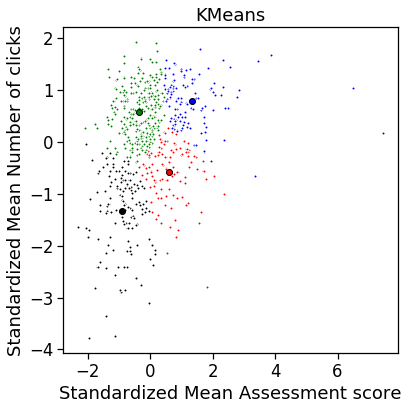

In [49]:
from sklearn.metrics.pairwise import pairwise_distances_argmin
fig = plt.figure(figsize=(6, 6))
colors = ['red', 'green', 'blue', 'black']
# Get distance between data points and cluster centers to determine nearest cluster
center = pairwise_distances_argmin(xs_p, kmeans.cluster_centers_)
# Get figure axis
ax = fig.add_subplot(1, 1, 1)
# Iterate over clusters 
for k in range(n_clusters):
    # Get the data points that belong to the cluster-k 
    _members = center == k
    # Plot the data points
    ax.plot(xs_p[_members, 0], xs_p[_members, 1], 'w',
            markerfacecolor=colors[k], marker='.')
    # Get cluster center
    cluster_center = kmeans.cluster_centers_[k]
    # Plot the cluster center
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=colors[k],
            markeredgecolor='k', markersize=6)
    
ax.set_title('KMeans')
plt.xlabel('Standardized Mean Assessment score')
plt.ylabel('Standardized Mean Number of clicks')


### Predict the final result
Use supervised learning to create a predictive model using the final result as labels
- How to construct the predictive model
- How to measure predictive model performance
 -  We will calculate the area under the receiver operating characteristic curve (AUC), 
 the probability that a classifier will rank a random positive instance higher than a random negative
 - The receiver operating characteristic curve (ROC) is a measure of a binary classifier system performance when varying
  the discrimination threshold.  
- Which classification model and hyper-parameters to use
- How to use the data for training


In [18]:
# Import machine learning methods
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier


Set label of the data
- Make a binary classification to simplify the prediction
 - We care initially more about passing or failing than the nuances within


In [50]:
# Student final result
labels = student_info_and_assessment_and_vle.groupby(by='id_student').final_result.first()
labels = pd.DataFrame(labels)
labels.loc[labels['final_result'] == 'Withdrawn'] = 'Fail'
labels.loc[labels['final_result'] == 'Distinction'] = 'Pass'
labels['code'] = labels.final_result.astype('category').cat.codes
ys = labels.code.values
assert ys.shape[0] == xs.shape[0]


Preprocess the data set
- Split in test and train parts
- Scale the data with standardization (z-score), subtracting the mean from the individual values and then divide
 by the standard deviation.

In [19]:
# Split the data set
X_train, X_test, y_train, y_test = train_test_split(xs, ys, random_state=RND_SEED)
# Standardize the data
sc_x = StandardScaler()
X_train = sc_x.fit_transform(X_train)
X_test = sc_x.transform(X_test)


Train classification models and report performance measures


In [29]:
# Create the different classifiers
classifiers = {'Decision Tree': DecisionTreeClassifier(random_state=RND_SEED), 
               'Logistic Regression': LogisticRegression(random_state=RND_SEED),
               'Naive Bayes': GaussianNB(),
               'Random Forest': RandomForestClassifier(random_state=RND_SEED),
               'K-Nearest Neighbors': KNeighborsClassifier(),
               'MLP': MLPClassifier(random_state=RND_SEED),
               }
# Iterate over the classifiers
for clf_name, clf in classifiers.items():
    # Fit a model on the training data
    clf.fit(X_train, y_train)
    # Predict the class of the test data with the trained model
    y_hat = clf.predict(X_test)
    # Measure the performance based on correct and incorrect classification against the actual class
    cm = metrics.confusion_matrix(y_test, y_hat)
    print('{} confusion matrix:\n{}'.format(clf_name, cm))
    # Calculate the True and False Positive rates for the ROC curve
    fpr, tpr, _ = metrics.roc_curve(y_test, y_hat)
    # Get the Area under the ROC curve
    auc = metrics.auc(fpr, tpr)
    print('{} AUC:{:.3f}'.format(clf_name, auc))


Decision Tree confusion matrix:
[[ 12  32]
 [ 15 111]]
Decision Tree AUC:0.577
Logistic Regression confusion matrix:
[[  7  37]
 [  1 125]]
Logistic Regression AUC:0.576
Naive Bayes confusion matrix:
[[ 12  32]
 [  4 122]]
Naive Bayes AUC:0.620
Random Forest confusion matrix:
[[ 13  31]
 [ 14 112]]
Random Forest AUC:0.592
K-Nearest Neighbors confusion matrix:
[[ 10  34]
 [  3 123]]
K-Nearest Neighbors AUC:0.602
MLP confusion matrix:
[[  8  36]
 [  2 124]]
MLP AUC:0.583


/Users/erikhemberg/mypy37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/erikhemberg/mypy37/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Can we determine the best model
- How will the model perform on an independent data set
- How much of the performance was dependent on the test/train data split?
 - Try more splits of the data with cross-validation
- What about bias: in the model or in the data
 

/Users/erikhemberg/mypy37/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Text(0, 0.5, 'AUC')

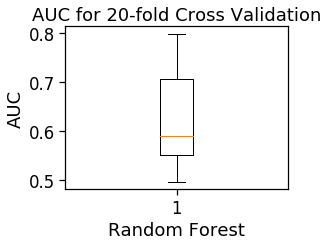

In [34]:
from sklearn.model_selection import StratifiedKFold
# Split the data in n different folds
n_folds = 20
cv = StratifiedKFold(n_splits=n_folds)
# Get which data is in each split
cv_splits = cv.split(xs, ys)
# Test only one classification model for now
clf = RandomForestClassifier(random_state=RND_SEED)
clf_name = 'Random Forest'
# Data structure for storing AUCs
aucs = []
# Iterate over the data splits
for train, test in cv_splits:
    # Scale the data
    xs[train] = sc_x.fit_transform(xs[train])
    xs[test] = sc_x.transform(xs[test])
    # Train classifier
    clf.fit(xs[train], ys[train])
    # Predict classes
    y_hat = clf.predict(xs[test])
    # Get ROC curve
    fpr, tpr, _ = metrics.roc_curve(ys[test], y_hat)
    # Get AUC
    auc = metrics.auc(fpr, tpr)
    # Store AUC
    aucs.append(auc)
    
# Plot the AUCs
fig = plt.figure(figsize=(4, 3))
_ = plt.boxplot(aucs)
plt.title('AUC for {}-fold Cross Validation'.format(n_folds))
plt.xlabel(clf_name)
plt.ylabel('AUC')


- Was there a dependence on the random seed used when training the model?
 - Try more instances of the classification model with different random seeds


            name       auc
0  Random Forest  0.592172
1            MLP  0.582973
2  Random Forest  0.592172
3            MLP  0.582973
4  Random Forest  0.561508


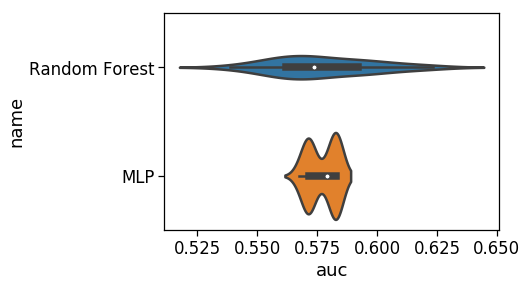

In [51]:
# Ignore warnings
import warnings
warnings.filterwarnings(action='ignore')
# Get random seeds
rnd_seeds = range(30)
# Data structure for storing AUCs for the classifiers
all_aucs = {'name': [], 'auc': []}
# Iterate over the random seeds
for rnd_seed in rnd_seeds:
    # Get classifier instances
    classifiers = {'Random Forest': RandomForestClassifier(random_state=rnd_seed),
                   'MLP': MLPClassifier(random_state=rnd_seed),
                   }
    # Iterate over classifiers
    for clf_name, clf in classifiers.items():
        # Train classifier
        clf.fit(X_train, y_train)
        # Predict classes
        y_hat = clf.predict(X_test)
        # Get ROC
        fpr, tpr, _ = metrics.roc_curve(y_test, y_hat)
        # Get AUC
        auc = metrics.auc(fpr, tpr)
        # Store AUC and  classifier
        all_aucs['name'].append(clf_name)
all_aucs['auc'].append(auc)
              
# Create data frame from classification data
_df = pd.DataFrame(all_aucs, index=range(len(rnd_seeds)*len(classifiers)))
print(_df.head())
# Plot the AUCs
sns.violinplot(y='name', x='auc', data=_df)


Are the differences in AUC between the classifiers statistically significant
- What statistical test can we use?
- Can we reject the hypothesis from the statistical test
 - Should we use p-value or confidence bounds


KS-test MLP p-value: 4.440892098500626e-16
KS-test Random Forest p-value: 1.5543122344752192e-15
Normal: False


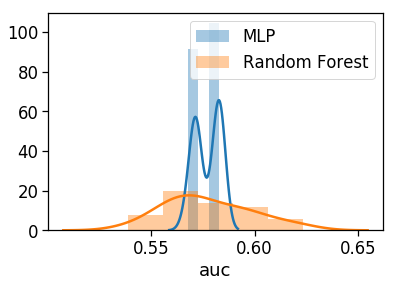

In [52]:
# Import stats libraries
from scipy.stats import  kstest, ttest_ind, ranksums

# Group data by classifier name
groups = _df.groupby(by='name')
# Check if the data follows a normal distribution
normal = True
# Significance level
alpha = 0.05
# Iterate over groups
for name, group in groups:
    # Plot data
    sns.distplot(group.auc, label=name)
    # Data distribution normal
    # KS test if the data is normal
    _, p_value = kstest(group.auc, 'norm')
    print('KS-test {} p-value: {}'.format(name, p_value))
    if p_value < alpha:
        normal = False
        
print('Normal: {}'.format(normal))
plt.legend()


In [53]:
# Distribution was not normal
# Get values from each classifier
a = groups.get_group('Random Forest').auc
b = groups.get_group('MLP').auc
significance_test = ranksums

# Test for significant difference
_, p_value = significance_test(a, b)
print('Significant difference: {} (p_value: {}, alpha: {}, normal: {})'.format(p_value < alpha, p_value, alpha, normal))

Significant difference: False (p_value: 0.5542678363243182, alpha: 0.05, normal: False)
